## Data Source

- https://www.kaggle.com/datasets/luisblanche/covidct (Generalization-dataset1)
- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (Generalization-dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Training)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Training)

### Transfer Learning Links
- https://keras.io/guides/transfer_learning/
- https://keras.io/examples/vision/reptile/
- https://keras.io/guides/making_new_layers_and_models_via_subclassing/


In [1]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2023-11-20 17:08:11.495950: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 17:08:11.525786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 17:08:11.525812: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 17:08:11.525830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 17:08:11.531585: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

## Importing Relevant Libraries

In [1]:
import pandas as pd
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)
## Imports libs
# from omnixai.data.image import Image
# from omnixai.preprocessing.image import Resize
# from omnixai.explainers.vision.specific.gradcam import GradCAM

2023-11-20 17:17:29.109416: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 17:17:29.139373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 17:17:29.139398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 17:17:29.139417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 17:17:29.145213: I tensorflow/core/platform/cpu_feature_g

## Renaming images data to Specified format

In [2]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))


In [3]:
path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_NonCOVID/'
prefix2 = 'ct_noncovid'
# renameImageFiles(path1, prefix1,'png')
# renameImageFiles(path2, prefix2,'png')
# renameImageFiles(path2, prefix2,'jpg')

## Data Preprocessing
### Processing images for machine learning to create two-class dataset

In [4]:
def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df   

#### Processing CT_scan Covid-19  CT_scan nonCovid-19 images

In [5]:
ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
#Concatenating the two data frame to create a dataset ready for machine learning
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((4649,300,300,1))
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
cvd_imgs_dataset = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
output_label_y = np.array(cvd_imgs_dataset[['output_encode_0','output_encode_1']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))

Input_x Data Shape: 
(4649, 300, 300, 1)
Output_y Data Shape: 
(4649, 2)


#### visualize first 5 images from the dataset

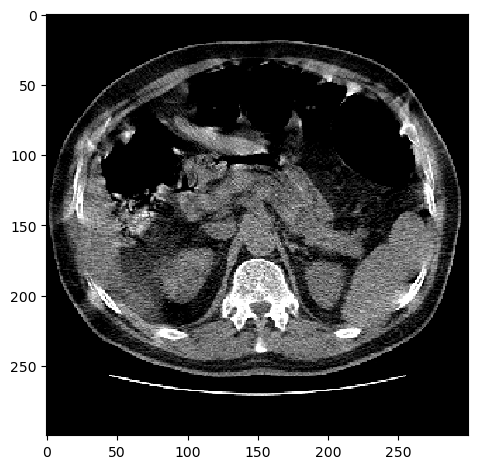

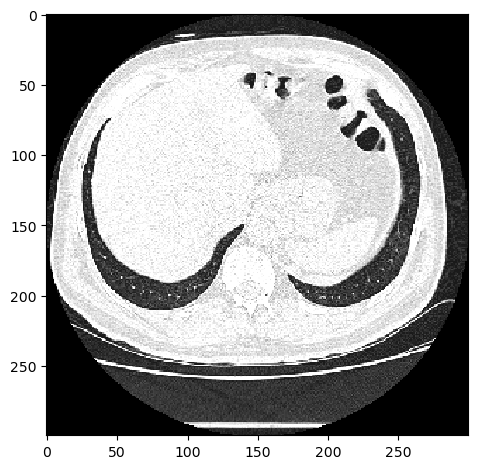

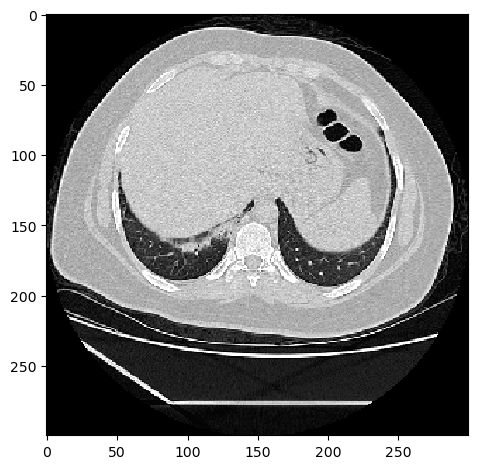

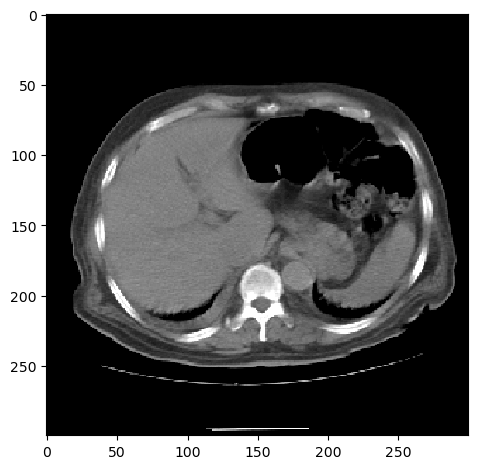

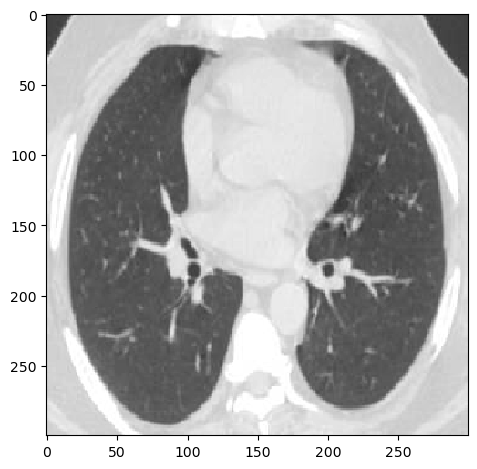

In [6]:
for i in range(5):
    imshow(input_data_x[i])
    show()

### Feature Scaling

#### **Splitting the dataset into the Training set and Test set**

In [7]:
from sklearn.model_selection import train_test_split

train_features_orgn, test_features_orgn, train_labels_orgn, test_labels_orgn = train_test_split(
    input_data_x, output_label_y, test_size=.20, random_state=42)

### Loading Dataset for Second Task

In [8]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))

path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_NonCOVID/'
prefix2 = 'ct_noncovid'

def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df


ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
display(cvd_imgs_dataset)

input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((14486,300,300,1))#dataset1=746
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
cvd_imgs_dataset_ = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
output_label_y = np.array(cvd_imgs_dataset_[['output_encode_0','output_encode_1']])
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


,0,1,2,3,4,5,6,7,8,9,...,89991,89992,89993,89994,89995,89996,89997,89998,89999,class_label
ct_covid_2341.png,0,1,4,4,0,7,7,0,6,2,...,7,2,3,8,6,0,0,0,8,1
ct_noncovid_3471.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_1693.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_4932.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_3327.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ct_covid_7200.png,2,4,2,3,1,3,2,4,0,4,...,3,0,2,2,4,4,4,1,0,1
ct_covid_7578.png,5,2,3,0,0,0,4,6,1,1,...,4,7,4,0,5,0,0,3,2,1
ct_noncovid_5517.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_noncovid_6719.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Input_x Data Shape: 
(14486, 300, 300, 1)
Output_y Data Shape: 
(14486, 2)


In [9]:
from sklearn.model_selection import train_test_split

train_features_gen_2, test_features_gen_2, train_labels_gen_2, test_labels_gen_2 = train_test_split(
    input_data_x, output_label_y, test_size=.50, random_state=42)


### Data Augmentation

In [10]:
image_size = 300
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_features_gen_2)

In [11]:
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'
        
def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    # df['Probality'] = np.max(np.array(df.iloc[:,:7]))
    #df.drop([0,1,2,3,4,5,6,7,8,9],axis =1,inplace=True)
    #print(df.head(100))
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()
    
    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__, 
                    predicted_labels=predictions)
    

### Building Model

In [12]:
def CNN_Mod(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
    '''
    CNN_Mod(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
        model = CNN Model
        num_hl = number of hidden layers
        hl_list = list of hidden layers
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))
    inputs = tf.keras.layers.Input(shape=inputShape)
    # Augment data.
    augmented = data_augmentation(inputs)
    
    #connnnvolultion layer 1 with Map-pooling
    conv_layer_1 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,strides = stride_poolSize, activation = hl_conv_activation)(augmented)
    conv_layer_1_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_1)
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_1_max_pool)
    
    #connnnvolultion layer 1 with Map-pooling
    conv_layer_2 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,strides = stride_poolSize, activation = hl_conv_activation)(x1)
    conv_layer_2_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_2)
    x2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_2_max_pool)
    
    flatten_layer = tf.keras.layers.Flatten()(x2)
    
    dense_layers = tf.keras.layers.Dense(units = hl_list[0], activation = hl_conv_activation)(flatten_layer)
    dense_layers = tf.keras.layers.Dropout(dropout_val[0])(dense_layers)
    
    dense_layers = tf.keras.layers.Dense(units = hl_list[1], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[1])(dense_layers)
    
    dense_layers = tf.keras.layers.Dense(units = hl_list[2], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[2])(dense_layers)
    
    dense_layers = tf.keras.layers.Dense(units = hl_list[3], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[3])(dense_layers)
    
    logits = tf.keras.layers.Dense(units = 2, activation = ol_activation)(dense_layers)
    
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs,outputs=logits)
    
    return model


def compile_model(model, loss_, learningRate, metrics_):
    '''
    def compile_model(DNN, loss_, learningRate, metrics_):
    DNN: the model
    loss_: the loss function
    learningRate: learning rate
    metrics_: metrics of interest [mse', 'mae'] #since a regression model
    '''
    model.compile(tf.keras.optimizers.Adam(learning_rate=learningRate,weight_decay=0.001),loss=loss_,metrics=metrics_)
    return model

def buildModel(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
  '''
  def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
  '''
  history = model.fit(
    train_features_orgn, 
    train_labels_orgn,
    validation_split = val_split_size,
    batch_size = batch_size_, 
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
    ]
    )
  
  return history

def evaluateModel_loss(history):
    print()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Training loss','Validation loss'], loc = 'upper left')
    plt.savefig("Training_validation_loss_with_i.jpg")
    plt.show()
    plt.close()
    #plt.show()
    print()
def evaluateModel_accuracy(history):
    print()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
    #plt.show()
    plt.savefig("Training_validation_accuracy_with_i.jpg")
    plt.show()
    plt.close()
    print()

print(CNN_Mod.__doc__)


    CNN_Mod(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
        model = CNN Model
        num_hl = number of hidden layers
        hl_list = list of hidden layers
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    


### EWC Implementation

In [14]:
# Train task model with EWC regularization
from tensorflow.keras.metrics import CategoricalAccuracy
from tqdm import tqdm
from tensorflow.keras.metrics import CategoricalAccuracy
from tqdm import tqdm

def train_task_with_ewc(task_model, x_train,y_train,x_train_val,y_train_val, prior_weights, task_epochs, regularization_strength,batch_size):
    optimizer = tf.keras.optimizers.Adam()  # Define the optimizer
    batch_size = batch_size
    history = {'loss': [], 'val_loss': [],'accuracy': [], 'val_accuracy':[]}  # To store loss and accuracy history
    
    for epoch in tqdm(range(task_epochs)):
        num_batches = len(x_train) // batch_size
        #print(f"Epoch {epoch + 1}/{task_epochs}")
        # Training
        total_loss = 0
        total_accuracy = 0
        total_val_loss = 0
        total_val_accuracy = 0

        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
            with tf.GradientTape() as tape:
                logits = task_model(x_train[start:end])
                task_loss = tf.losses.categorical_crossentropy(y_train[start:end], logits, from_logits=True)
                regularization_loss = compute_ewc_regularization(task_model, prior_weights)
                total_loss_batch = task_loss + regularization_strength * regularization_loss
            gradients = tape.gradient(total_loss_batch, task_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, task_model.trainable_variables))
            total_loss += tf.reduce_sum(total_loss_batch)
            total_accuracy += CategoricalAccuracy()(y_train[start:end], logits)

        # Calculate and print average loss and accuracy
        avg_total_loss = total_loss / num_batches
        avg_total_accuracy = total_accuracy / num_batches
        history['loss'].append(avg_total_loss.numpy())
        history['accuracy'].append(avg_total_accuracy.numpy())
        #print(f"Epoch {epoch + 1}/{task_epochs} - Average Loss: {avg_total_loss:.4f}, Average Accuracy: {avg_total_accuracy:.4f}")
    return history

# Compute EWC regularization loss
def compute_ewc_regularization(task_model, prior_weights):
    ewc_loss = 0
    for current_weights, prior_weights in zip(task_model.trainable_variables, prior_weights):
        ewc_loss += tf.reduce_sum(tf.square(current_weights - prior_weights))
    return ewc_loss

### Training on Task 1(Base Model(using pretrained weight from Task 1 model))

In [16]:
cnn_1  = tf.keras.models.Sequential()
cnn_1  = CNN_Mod(cnn_1, 4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.00,0.00],(300,300,1),116,8,2)
cnn_1.load_weights('model_EWC_1_weight.h5')
cnn_1  = compile_model(cnn_1,'categorical_crossentropy',0.0010621475226496656,['accuracy'])

### Training on Task 2 (Task Specific Model)

In [20]:
cnn_2  = tf.keras.models.Sequential()
cnn_2  = CNN_Mod(cnn_2, 4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.00,0.00],(300,300,1),116,8,2)
#compile and run model here
cnn_2  = compile_model(cnn_2,'categorical_crossentropy',0.0010621475226496656,['accuracy'])

In [97]:
input_shape = test_features_gen_2.shape[1:]
num_classes = 2
task_epochs = 50
regularization_strength = 2.0#best = 2.0
batch_size = 256

In [98]:
# Train task model with EWC regularization
history = train_task_with_ewc(cnn_2, train_features_gen_2, train_labels_gen_2,val_features_gen_2, val_labels_gen_2,
                              cnn_1.trainable_variables, task_epochs, regularization_strength,batch_size)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2023-08-15 16:17:22.900599: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-15 16:17:22.900625: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
100%|████████████████████████████████████████| 50/50 [2:42:27<00:00, 194.96s/it]


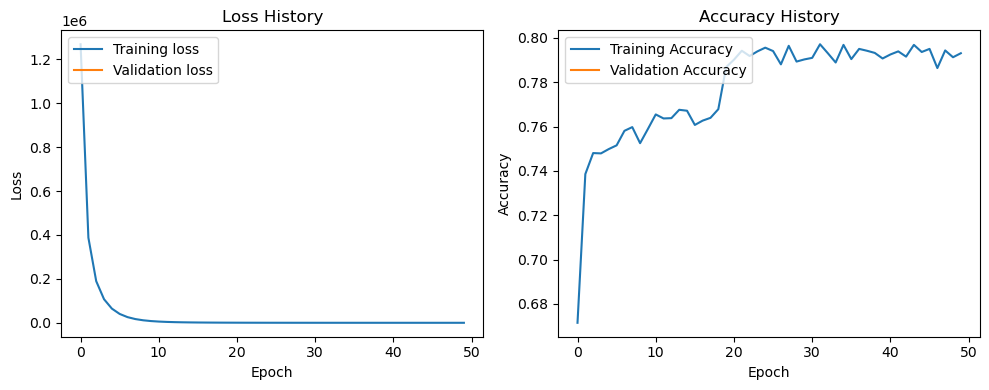

In [99]:
# Plot loss and accuracy history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend(['Training loss','Validation loss'], loc = 'upper left')


plt.subplot(1, 2, 2)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [101]:
cnn_2.save('CNN_2_EWC_V3.h5')
cnn_2.save_weights('CNN_2_EWC_V3_WEIGHT.h5')

In [14]:
cnn_2 = tf.keras.models.load_model('CNN_2_EWC_V3.h5')

### Evaluation

In [15]:
loss, accuracy = cnn_2.evaluate(test_features_gen_2,test_labels_gen_2)
loss_base, accuracy_base = cnn_2.evaluate(test_features_orgn,test_labels_orgn)
print(f"Task 1 - EWC Loss: {loss_base:.4f}, EWC Accuracy: {accuracy_base:.4f}")
print(f"Task 2 - EWC Loss: {loss:.4f}, EWC Accuracy: {accuracy:.4f}")
print()

30/30 [==============================] - 4s 147ms/step - loss: 0.6559 - accuracy: 0.8226
Task 1 - EWC Loss: 0.6559, EWC Accuracy: 0.8226
Task 2 - EWC Loss: 0.4776, EWC Accuracy: 0.7933



227/227 [==============================] - 34s 151ms/step


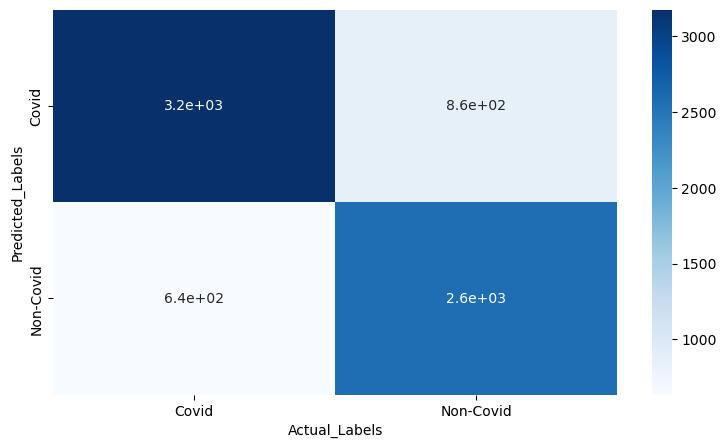

test accuracy = 79.33176860416954%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7933
Precision: 0.7938
Recall: 0.7933
F1 Score: 0.7928
30/30 [==============================] - 4s 149ms/step


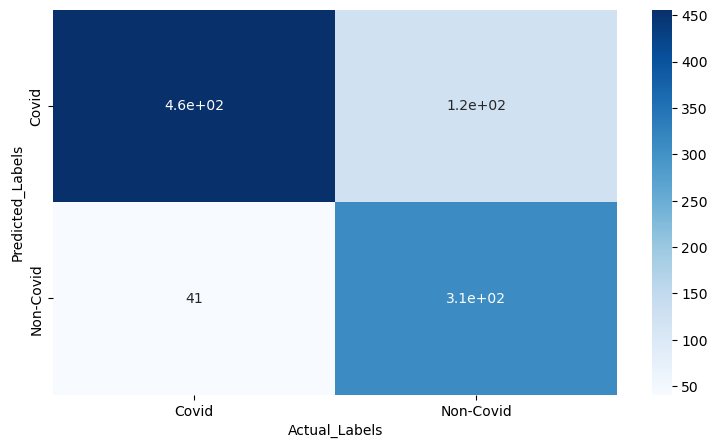

test accuracy = 82.25806451612904%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8226
Precision: 0.8312
Recall: 0.8226
F1 Score: 0.82


In [18]:
import seaborn as sns
getModelEvaluation(cnn_2,test_features_gen_2,test_labels_gen_2)
getModelEvaluation(cnn_2 ,test_features_orgn,test_labels_orgn)